# Homework 9: Conway's Game of Life 
by Rustam Guseyn-zade ([link canvas](https://skoltech.instructure.com/courses/3546/users/9673))

## Table of contents
* [The Game of Life sequentially](#The-Game-of-Life-sequentially)
* [The Game of Life parallel](#The-Game-of-Life-parallel)
* [Gosper's glider gun](#Gosper's-glider-gun)
* [Number of the living cells vs time](#Number-of-the-living-cells-vs-time)

In [1]:
#import needed libraries
import cv2
import glob
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import os
from PIL import Image
import random
import time
import tracemalloc

## The Game of Life sequentially

In [2]:
def pixels_map(width, height):
    plain_map = np.zeros(height * width)
    plain_map[:int((width * height) / 2)] = 1
    plain_map = np.random.permutation(plain_map)
    pixels = np.zeros((height, width))
    for i in range(height):
        pixels[i] = plain_map[i*width:(i+1)*width]
    return pixels

In [3]:
def game_of_life(pixels, steps_limit = 100, filename='life'):
    step = 0
    number_of_alive = []
    height = pixels.shape[0]
    width = pixels.shape[1]
    while sum(sum(pixels)) != 0 and step != steps_limit:
        new_pixels = pixels.copy()
        for i in range(height):
            for j in range(width):
                total = int((pixels[i, (j-1) % width] + pixels[i, (j+1) % width] +
                             pixels[(i-1) % height, j] + pixels[(i+1) % height, j] +
                             pixels[(i-1) % height, (j-1) % width] + pixels[(i-1) % height, (j+1) % width] +
                             pixels[(i+1) % height, (j-1) % width] + pixels[(i+1) % height, (j+1) % width]))
 
                if pixels[i, j] == 1:
                    if (total < 2) or (total > 3):
                        new_pixels[i, j] = 0
                else:
                    if total == 3:
                        new_pixels[i, j] = 1
        
        number_of_alive.append(sum(sum(pixels)))
        pixels = new_pixels
        if filename is not None:
            plt.imshow(pixels, cmap='gray')
            plt.savefig('map_' + '{0:08}'.format(step) + '.png')
        print(f"survived for {step+1}", end="\r")
        step+=1

    fp_in = "map_*.png"
    
    if filename is not None:
        fp_out = f"{filename}.gif"
        img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
        img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)
    
    for filePath in sorted(glob.glob(fp_in)):
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)
    if filename is not None:
        print(f"Animation saved in file {fp_out}")
    return number_of_alive

Animation saved in file life.gif


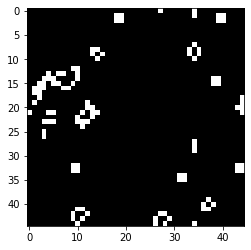

In [4]:
pixels = pixels_map(45, 45)
_ = game_of_life(pixels, steps_limit = 200)

## The Game of Life parallel

In [5]:
%%writefile life.py
# Create file life.py
import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import os
from PIL import Image

def pixels_map(width, height):
    plain_map = np.zeros(height * width)
    plain_map[:int((width * height) / 2)] = 1
    plain_map = np.random.permutation(plain_map)
    pixels = np.zeros((height, width))
    for i in range(height):
        pixels[i] = plain_map[i*width:(i+1)*width]
    return pixels

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

pixels = pixels_map(45, 45)

chunk_size = 45//size + 1
chunk_head = chunk_size * rank
chunk_tail = chunk_size * (rank + 1)
if chunk_tail > 45:
    chunk_tail = 45

pixels_cur = pixels[:,chunk_head:chunk_tail]
pixels_cur = np.concatenate((np.array([np.zeros(45)]).T, pixels_cur), axis=1)
pixels_cur = np.concatenate((pixels_cur, np.array([np.zeros(45)]).T), axis=1)
step = 0
height = pixels_cur.shape[0]
width = pixels_cur.shape[1]

if size != 1:
        it_to_sendr = rank+1 if rank != size-1 else 0
        it_to_sendl = rank-1 if rank != 0 else size-1
        comm.send(pixels_cur[:,1], dest=it_to_sendl)
        comm.send(pixels_cur[:,width-1], dest=it_to_sendr)
        left_ghost = comm.recv(source=it_to_sendl)
        right_ghost = comm.recv(source=it_to_sendr)
        pixels_cur[:,1] = left_ghost
        pixels_cur[:,width-1] = right_ghost

height = pixels_cur.shape[0]
width = pixels_cur.shape[1]
        
step = 0
while sum(sum(pixels_cur)) != 0 and step != 200:
    new_pixels = pixels_cur.copy()
    for i in range(height):
        for j in range(1, width-1):
            total = int((pixels_cur[i, (j-1)] + pixels_cur[i, (j+1)] +
                             pixels_cur[(i-1) % height, j] + pixels_cur[(i+1) % height, j] +
                             pixels_cur[(i-1) % height, (j-1)] + pixels_cur[(i-1) % height, (j+1)] +
                             pixels_cur[(i+1) % height, (j-1)] + pixels_cur[(i+1) % height, (j+1)]))
 
            if pixels_cur[i, j] == 1:
                if (total < 2) or (total > 3):
                    new_pixels[i, j] = 0
            else:
                if total == 3:
                    new_pixels[i, j] = 1
    #part with ghost cells
    if size != 1:
        total_zero = np.zeros(height)
        for i in range(height):
            total_zero[i] = int((2*pixels_cur[i, 1] +
                          pixels_cur[(i-1) % height, 0] + pixels_cur[(i+1) % height, 0] +
                          2*pixels_cur[(i-1) % height, 1] +
                          2*pixels_cur[(i+1) % height, 1]))
        total_n = np.zeros(height)
        for i in range(height):
            total_n[i] = int((2*pixels_cur[i, width-2] +
                        pixels_cur[(i-1) % height, width-1] + pixels_cur[(i+1) % height, width-1] +
                        2*pixels_cur[(i-1) % height, width-2] +
                        2*pixels_cur[(i+1) % height, width-2]))
        comm.send(total_zero, dest=it_to_sendl)
        comm.send(total_n, dest=it_to_sendr)
        left_ghost = comm.recv(source=it_to_sendl)
        right_ghost = comm.recv(source=it_to_sendr)
        for i in range(height):
            total = (total_zero[i] + left_ghost[i]) // 2
            if pixels_cur[i, 0] == 1:
                if (total < 2) or (total > 3):
                    new_pixels[i, 0] = 0
            else:
                if total == 3:
                    new_pixels[i, 0] = 1
            total = (total_n[i] + right_ghost[i]) // 2
            if pixels_cur[i, width-1] == 1:
                if (total < 2) or (total > 3):
                    new_pixels[i, width-1] = 0
            else:
                if total == 3:
                    new_pixels[i, width-1] = 1
    pixels_cur = new_pixels
    step += 1
    pixels_all = comm.gather(pixels_cur[:,1:width-1].T, root=0)
    if rank == 0:
        pixels_all = np.concatenate(pixels_all)
        plt.imshow(pixels_all, cmap='gray')
        plt.savefig('map_' + '{0:08}'.format(step) + '.png')
        print(f"step {step}", end='\r')
    comm.send(pixels_cur[:,1], dest=it_to_sendl)
    comm.send(pixels_cur[:,width-1], dest=it_to_sendr)
    left_ghost = comm.recv(source=it_to_sendl)
    right_ghost = comm.recv(source=it_to_sendr)
    pixels_cur[:,1] = left_ghost
    pixels_cur[:,width-1] = right_ghost
        
if rank == 0:
    fp_in = "map_*.png"
    fp_out = "mpilife.gif"
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=10, loop=0)
    
    for filePath in sorted(glob.glob(fp_in)):
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)
    print(f"Animation saved in file {fp_out}")

Overwriting life.py


In [6]:
!mpirun --allow-run-as-root -np 4 python3 life.py

Animation saved in file mpilife.gif


## Gosper's glider gun

Animation saved in file gilder_gun.gif


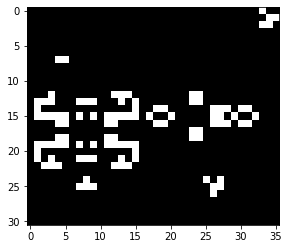

In [7]:
glider_gun =\
np.array([
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
])

_ = game_of_life(glider_gun, 100, 'gilder_gun')

## Number of the living cells vs time

Text(0.5, 1.0, 'Evolution of cells')

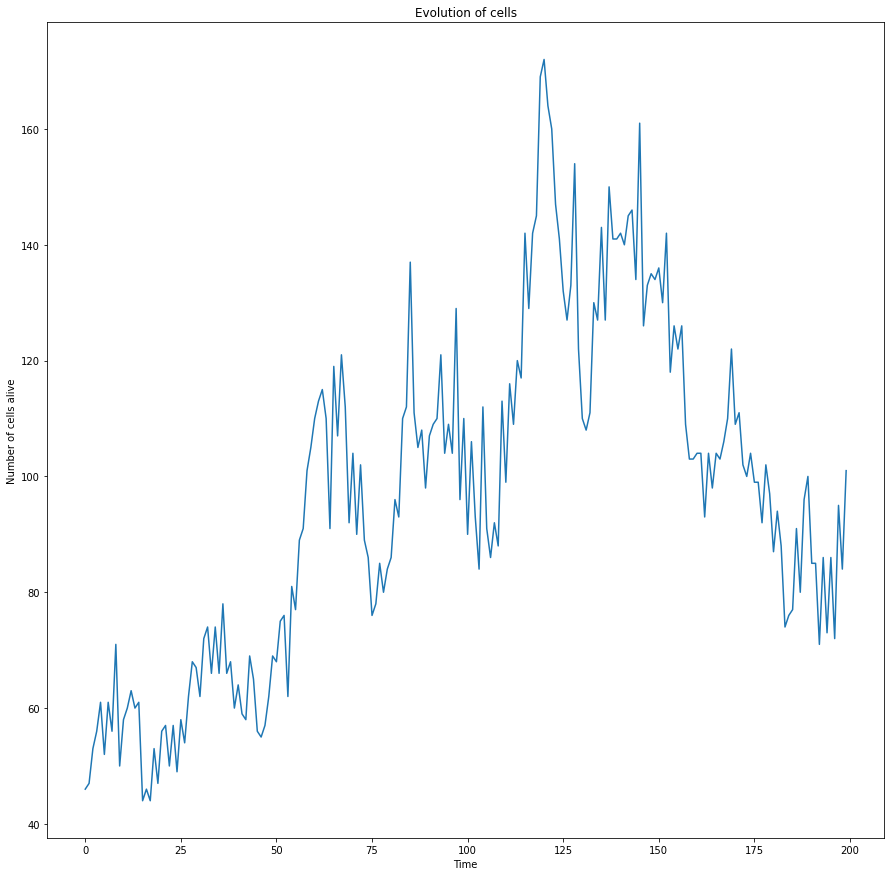

In [8]:
glider_gun_with_two_conditions =\
np.array([
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
])

alife = game_of_life(glider_gun_with_two_conditions, 200, None)
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(alife)
plt.ylabel('Number of cells alive')
plt.xlabel('Time')
plt.title('Evolution of cells')